# Project: Data Mining - Anomaly Detection and Multi-Class Classification  

## This notebook is realized by **Wiem Mehri & Rahma Aroua** 

## Introduction  

This project explores advanced data mining techniques for two main tasks: **anomaly detection (binary)** and **multi-class classification**. The work is based on the **Fish Dataset** from Kaggle, which contains morphological measurements of different fish species.  

## Part 1: Anomaly Detection (Binary)  
In this section, we will apply an **autoencoder (AE)** or **convolutional autoencoder (CAE)** these concepts to a real-world, diverse problem.

In [1]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fresh-and-not-fresh-fish-dataset/fresh and non-freh fish/fresh/20200517_085301.jpg
/kaggle/input/fresh-and-not-fresh-fish-dataset/fresh and non-freh fish/fresh/20200517_084411.jpg
/kaggle/input/fresh-and-not-fresh-fish-dataset/fresh and non-freh fish/fresh/20200517_084015.jpg
/kaggle/input/fresh-and-not-fresh-fish-dataset/fresh and non-freh fish/fresh/20200517_084329.jpg
/kaggle/input/fresh-and-not-fresh-fish-dataset/fresh and non-freh fish/fresh/20200517_084741.jpg
/kaggle/input/fresh-and-not-fresh-fish-dataset/fresh and non-freh fish/fresh/20200517_085346.jpg
/kaggle/input/fresh-and-not-fresh-fish-dataset/fresh and non-freh fish/fresh/20200517_084906.jpg
/kaggle/input/fresh-and-not-fresh-fish-dataset/fresh and non-freh fish/fresh/20200517_084451.jpg
/kaggle/input/fresh-and-not-fresh-fish-dataset/fresh and non-freh fish/fresh/20200517_084438.jpg
/kaggle/input/fresh-and-not-fresh-fish-dataset/fresh and non-freh fish/fresh/20200517_084532.jpg
/kaggle/input/fresh-and-not-fr

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

2025-04-24 09:03:41.925423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745485422.189131      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745485422.261687      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **📦1. Dataset Setup**

In [3]:

dataset_path ="/kaggle/input/fresh-and-not-fresh-fish-dataset/fresh and non-freh fish"

# List categories
print(os.listdir(dataset_path))


['fresh', 'non-fresh']


# **🖼️ 2. Load Images with Preprocessing**

In [4]:
def load_images(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)  
        img = cv2.resize(img, img_size)  
        img = img / 255.0  # Normaliize to [0,1]
        images.append(img)
        labels.append(label)  # Label: 0 (normal) or 1 (anomalous)
    return np.array(images), np.array(labels)

# Load fresh (normal) fish
fresh_images, fresh_labels = load_images(os.path.join(dataset_path, "fresh"), 0)

# Load not fresh (anomalous) fish
not_fresh_images, not_fresh_labels = load_images(os.path.join(dataset_path, "non-fresh"), 1)

# Combine datasets
X = np.vstack((fresh_images, not_fresh_images))
y = np.hstack((fresh_labels, not_fresh_labels))

print(f"Dataset size: {X.shape}, Labels: {y.shape}")

Dataset size: (40, 128, 128, 3), Labels: (40,)


#  🧪 3. Split and Prepare Training Data 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Only use normal data for training
X_train_normal = X_train[y_train == 0]

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Normal training data shape: {X_train_normal.shape}")

Training data shape: (32, 128, 128, 3), Test data shape: (8, 128, 128, 3)
Normal training data shape: (16, 128, 128, 3)


# 🧠 4. Build the Convolutional Autoencoder

In [6]:
input_shape = (128, 128, 3)

input_img = Input(shape=input_shape)

# Encoder
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2D(128, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="mse")


encoder = Model(input_img, encoded)

autoencoder.summary()

2025-04-24 09:03:57.476324: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 818ms/step - loss: 0.0722 - val_loss: 0.0617
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 0.0620 - val_loss: 0.0602
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - loss: 0.0578 - val_loss: 0.0524
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.0522 - val_loss: 0.0501
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - loss: 0.0490 - val_loss: 0.0477
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - loss: 0.0453 - val_loss: 0.0417
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.0411 - val_loss: 0.0406
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - loss: 0.0379 - val_loss: 0.0330
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - loss: 0.0324 - val_loss: 0.0298
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - loss: 0.0291 - val_loss: 0.0268
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - loss: 0.0259 - val_loss: 0.0261
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - loss: 0.0243 - val_lo

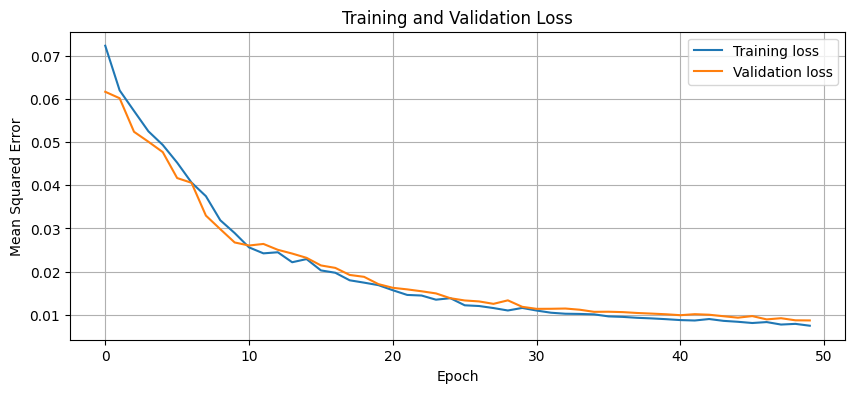

In [7]:
# Train the autoencoder on normal data only
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=8,
    shuffle=True,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# 🔍 5. Evaluate Anomaly Detection (Binary Classification)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


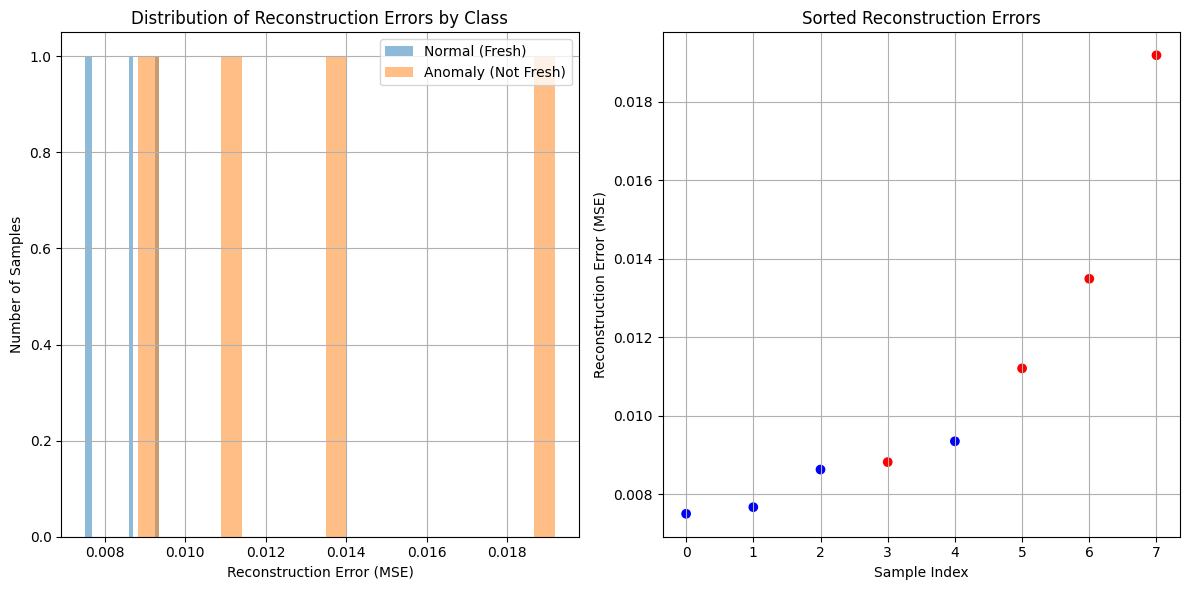

Anomaly detection threshold: 0.009243
Accuracy: 0.7500
Precision: 0.7500
Recall: 0.7500
F1 Score: 0.7500


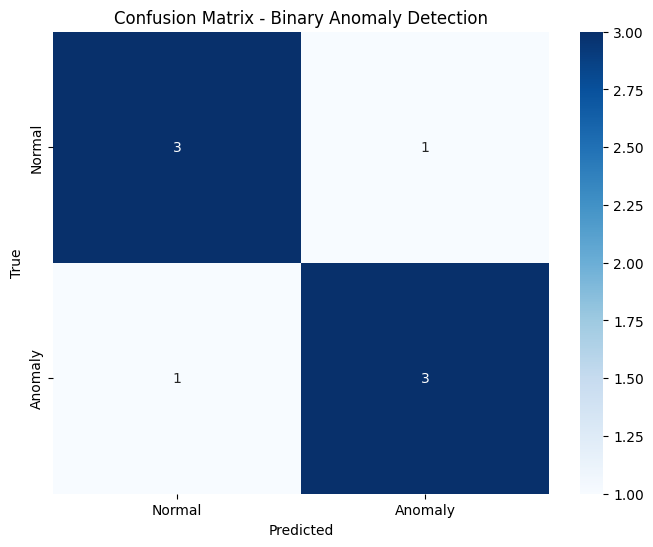

In [8]:
# Calculate reconstruction errors for test data
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - X_test_pred), axis=(1, 2, 3))

# Visualize reconstruction error distribution
plt.figure(figsize=(12, 6))

# Histogram of reconstruction errors by class
plt.subplot(1, 2, 1)
plt.hist(mse[y_test == 0], bins=20, alpha=0.5, label='Normal (Fresh)')
plt.hist(mse[y_test == 1], bins=20, alpha=0.5, label='Anomaly (Not Fresh)')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Number of Samples')
plt.title('Distribution of Reconstruction Errors by Class')
plt.legend()
plt.grid(True)

# Scatter plot of reconstruction errors
plt.subplot(1, 2, 2)
plt.scatter(range(len(mse)), sorted(mse), c=['blue' if y == 0 else 'red' for y in y_test[np.argsort(mse)]])
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Sorted Reconstruction Errors')
plt.grid(True)

plt.tight_layout()
plt.show()

# Determine optimal threshold for binary detection
mse_normal = mse[y_test == 0]
threshold = np.percentile(mse_normal, 95)  # 95th percentile as threshold

print(f"Anomaly detection threshold: {threshold:.6f}")

# Binary classification based on threshold
y_pred = (mse > threshold).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Binary Anomaly Detection')
plt.show()

# 🔄 Part 2 - Option 1 : Multi-Adaptive Thresholds

In this approach, we will define 
zthresholds for each class to perform multi-class classification.
 we'll start by creating a synthetic multi-class dataset from existing data
 then We'll divide the non-fresh fish into two categories: slightly altered and very altered.

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

In [10]:
X_pred = autoencoder.predict(X)
mse_all = np.mean(np.square(X - X_pred), axis=(1, 2, 3))


# 0: Fresh (normal), 1: Slightly altered, 2: Very altered
y_multiclass = y.copy()

# Among non-fresh fish (y=1), we identify those with higher reconstruction error

non_fresh_indices = np.where(y == 1)[0]
non_fresh_mse = mse_all[non_fresh_indices]
median_non_fresh_mse = np.median(non_fresh_mse)

# Non-fresh fish with MSE > median are classified as "very altered" (class 2)
for idx in non_fresh_indices:
    if mse_all[idx] > median_non_fresh_mse:
        y_multiclass[idx] = 2


class_counts = np.bincount(y_multiclass)
print(f"Multi-class distribution:")
print(f"Class 0 (Fresh): {class_counts[0]} samples")
print(f"Class 1 (Slightly altered): {class_counts[1]} samples")
print(f"Class 2 (Very altered): {class_counts[2]} samples")

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multiclass, test_size=0.2, stratify=y_multiclass, random_state=42
)

print(f"Multi-class training data shape: {X_train_multi.shape}")
print(f"Multi-class test data shape: {X_test_multi.shape}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Multi-class distribution:
Class 0 (Fresh): 20 samples
Class 1 (Slightly altered): 10 samples
Class 2 (Very altered): 10 samples
Multi-class training data shape: (32, 128, 128, 3)
Multi-class test data shape: (8, 128, 128, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
Threshold 1 (Fresh/Slightly altered): 0.010119
Threshold 2 (Slightly altered/Very altered): 0.012509


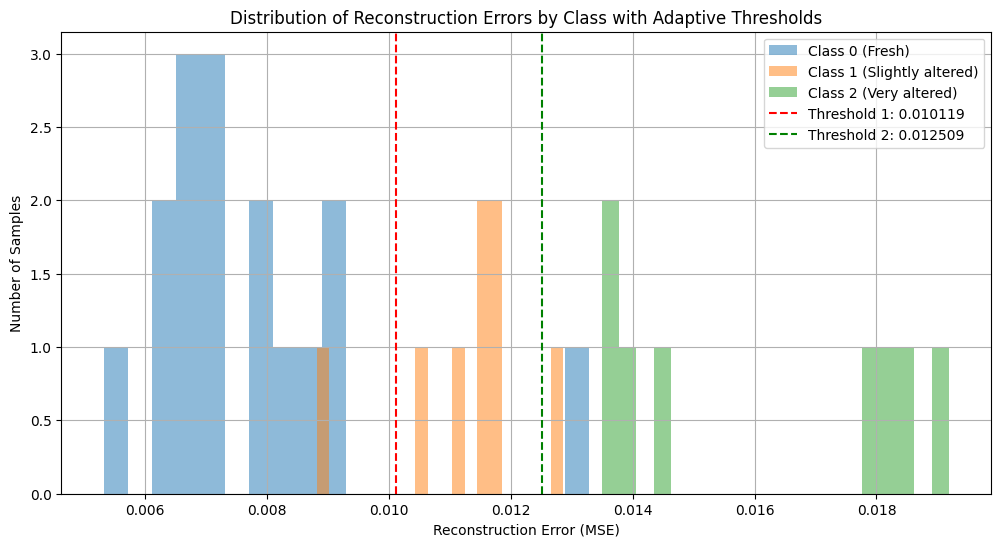

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Multi-class accuracy: 1.0000
Multi-class precision: 1.0000
Multi-class recall: 1.0000
Multi-class F1 score: 1.0000


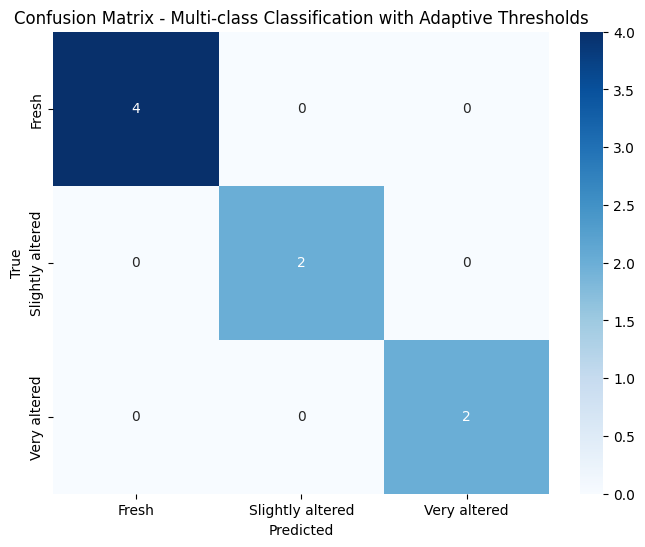

In [11]:
X_train_multi_pred = autoencoder.predict(X_train_multi)
mse_train_multi = np.mean(np.square(X_train_multi - X_train_multi_pred), axis=(1, 2, 3))


mse_class0 = mse_train_multi[y_train_multi == 0]
threshold1 = np.percentile(mse_class0, 95)  # 95th percentile of class 0


mse_class1 = mse_train_multi[y_train_multi == 1]
threshold2 = np.percentile(mse_class1, 95)  # 95th percentile of class 1

print(f"Threshold 1 (Fresh/Slightly altered): {threshold1:.6f}")
print(f"Threshold 2 (Slightly altered/Very altered): {threshold2:.6f}")


plt.figure(figsize=(12, 6))
plt.hist(mse_train_multi[y_train_multi == 0], bins=20, alpha=0.5, label='Class 0 (Fresh)')
plt.hist(mse_train_multi[y_train_multi == 1], bins=20, alpha=0.5, label='Class 1 (Slightly altered)')
plt.hist(mse_train_multi[y_train_multi == 2], bins=20, alpha=0.5, label='Class 2 (Very altered)')
plt.axvline(x=threshold1, color='r', linestyle='--', label=f'Threshold 1: {threshold1:.6f}')
plt.axvline(x=threshold2, color='g', linestyle='--', label=f'Threshold 2: {threshold2:.6f}')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Number of Samples')
plt.title('Distribution of Reconstruction Errors by Class with Adaptive Thresholds')
plt.legend()
plt.grid(True)
plt.show()


X_test_multi_pred = autoencoder.predict(X_test_multi)
mse_test_multi = np.mean(np.square(X_test_multi - X_test_multi_pred), axis=(1, 2, 3))


y_pred_multi = np.zeros_like(y_test_multi)
for i, mse_val in enumerate(mse_test_multi):
    if mse_val <= threshold1:
        y_pred_multi[i] = 0  # Class 0 (Fresh)
    elif mse_val <= threshold2:
        y_pred_multi[i] = 1  # Class 1 (Slightly altered)
    else:
        y_pred_multi[i] = 2  # Class 2 (Very altered)


accuracy_multi = accuracy_score(y_test_multi, y_pred_multi)
precision_multi = precision_score(y_test_multi, y_pred_multi, average='weighted')
recall_multi = recall_score(y_test_multi, y_pred_multi, average='weighted')
f1_multi = f1_score(y_test_multi, y_pred_multi, average='weighted')

print(f"Multi-class accuracy: {accuracy_multi:.4f}")
print(f"Multi-class precision: {precision_multi:.4f}")
print(f"Multi-class recall: {recall_multi:.4f}")
print(f"Multi-class F1 score: {f1_multi:.4f}")


cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fresh', 'Slightly altered', 'Very altered'], 
            yticklabels=['Fresh', 'Slightly altered', 'Very altered'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Multi-class Classification with Adaptive Thresholds')
plt.show()

# 🔄 Part 2 - Option 2 : Clustering in latent space

In this approach, we will extract the latent space using the autoencoder, then apply a clustering algorithm (K-means) to group the products into categories.

In [12]:
X
latent_space = encoder.predict(X)

n_samples = latent_space.shape[0]
latent_flat = latent_space.reshape(n_samples, -1)

print(f"Original latent space shape: {latent_space.shape}")
print(f"Flattened latent space shape: {latent_flat.shape}")

latent_train, latent_test, y_train_latent, y_test_latent = train_test_split(
    latent_flat, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training latent space shape: {latent_train.shape}")
print(f"Test latent space shape: {latent_test.shape}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Original latent space shape: (40, 16, 16, 128)
Flattened latent space shape: (40, 32768)
Training latent space shape: (32, 32768)
Test latent space shape: (8, 32768)


In [13]:
n_components = min(40, latent_flat.shape[0], latent_flat.shape[1])

# Apply PCA
pca = PCA(n_components=n_components) #compression images
latent_pca = pca.fit_transform(latent_flat)

# Show results
print(f"PCA latent space shape: {latent_pca.shape}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

# Split into training and testing sets
latent_pca_train, latent_pca_test, y_train_pca, y_test_pca = train_test_split(
    latent_pca, y, test_size=0.2, stratify=y, random_state=42
)


PCA latent space shape: (40, 40)
Cumulative explained variance: 1.0000


For n_clusters = 2, the average silhouette score is: 0.2222
For n_clusters = 3, the average silhouette score is: 0.1893
For n_clusters = 4, the average silhouette score is: 0.2034
For n_clusters = 5, the average silhouette score is: 0.1906


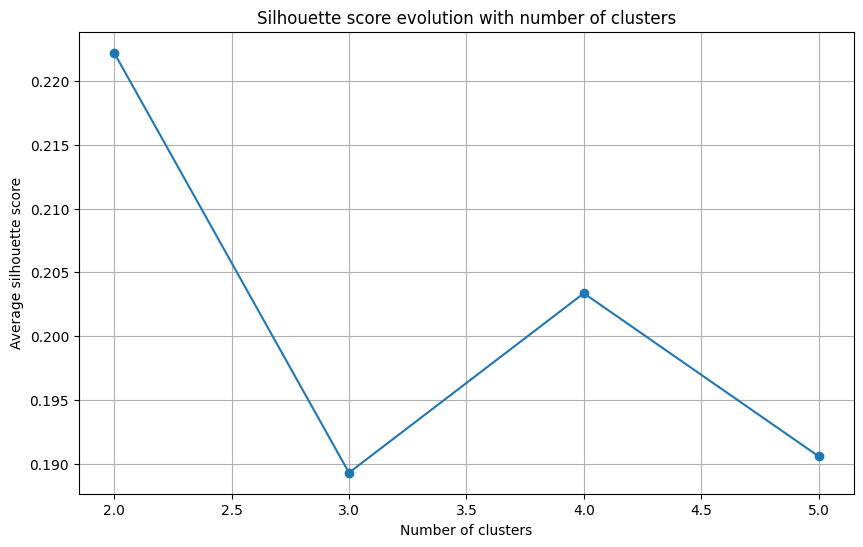

Optimal number of clusters: 2
Adjusted Rand Index (training): 0.0328
Adjusted Rand Index (test): 0.1200


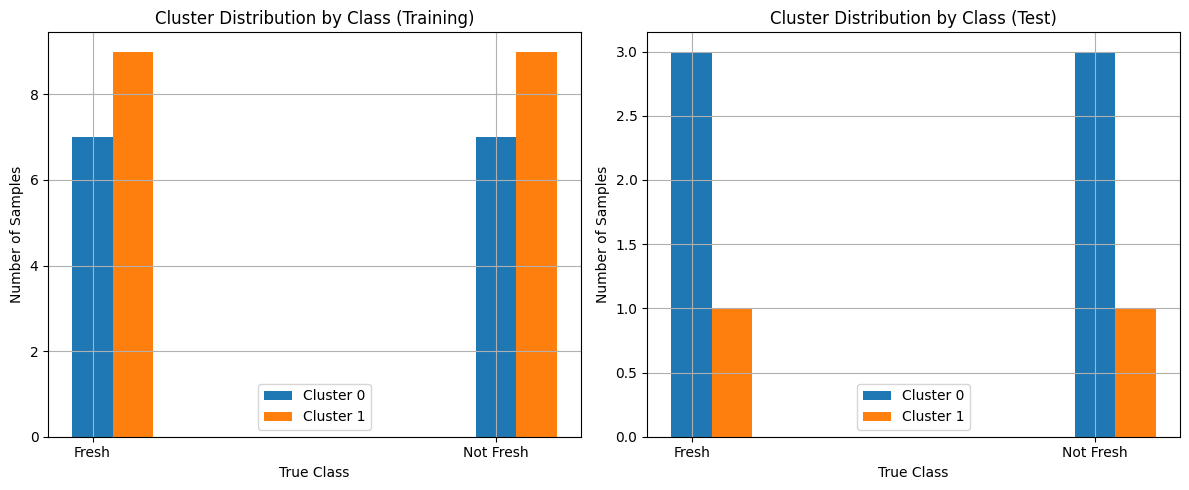

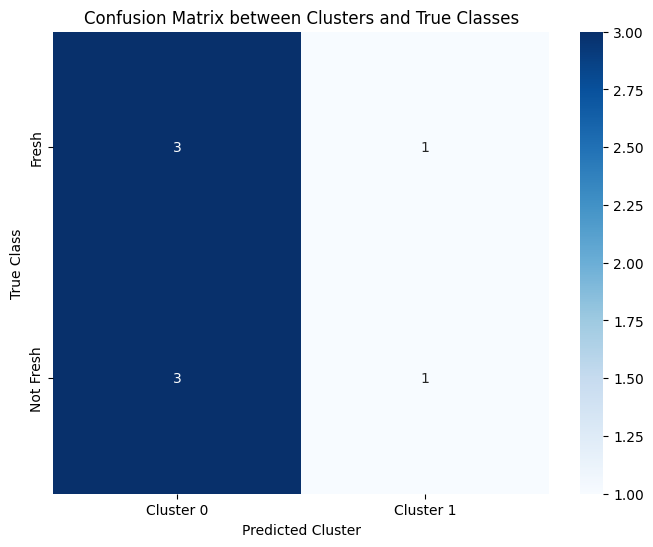

In [14]:
# Apply K-means for clustering in latent space
# Determine optimal number of clusters with silhouette score
silhouette_scores = []
range_n_clusters = range(2, 6)  # Test from 2 to 5 clusters

for n_clusters in range_n_clusters:
    # Initialize K-means model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    # Train the model
    cluster_labels = kmeans.fit_predict(latent_pca_train)
    # Calculate silhouette score
    silhouette_avg = silhouette_score(latent_pca_train, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg:.4f}")

# Visualize silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette score')
plt.title('Silhouette score evolution with number of clusters')
plt.grid(True)
plt.show()

# Select optimal number of clusters
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_n_clusters}")

# Apply K-means with optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
kmeans_optimal.fit(latent_pca_train)

# Predict clusters for training and test data
y_train_pred_cluster = kmeans_optimal.predict(latent_pca_train)
y_test_pred_cluster = kmeans_optimal.predict(latent_pca_test)

# Evaluate clustering with Adjusted Rand Index (ARI)
# ARI measures similarity between two cluster assignments
# A value close to 1 indicates strong correspondence with true labels
ari_train = -adjusted_rand_score(y_train_pca, y_train_pred_cluster)
ari_test = -adjusted_rand_score(y_test_pca, y_test_pred_cluster)

print(f"Adjusted Rand Index (training): {ari_train:.4f}")
print(f"Adjusted Rand Index (test): {ari_test:.4f}")

# Visualize cluster distribution relative to true classes
plt.figure(figsize=(12, 5))

# Cluster distribution for training data
plt.subplot(1, 2, 1)
for cluster in range(optimal_n_clusters):
    # Count number of samples of each true class in this cluster
    cluster_mask = (y_train_pred_cluster == cluster)
    class_counts = np.bincount(y_train_pca[cluster_mask].astype(int), minlength=2)
    plt.bar(np.arange(2) + 0.1*cluster, class_counts, width=0.1, 
            label=f'Cluster {cluster}')

plt.xlabel('True Class')
plt.ylabel('Number of Samples')
plt.title('Cluster Distribution by Class (Training)')
plt.xticks([0, 1], ['Fresh', 'Not Fresh'])
plt.legend()
plt.grid(True)

# Cluster distribution for test data
plt.subplot(1, 2, 2)
for cluster in range(optimal_n_clusters):
    # Count number of samples of each true class in this cluster
    cluster_mask = (y_test_pred_cluster == cluster)
    class_counts = np.bincount(y_test_pca[cluster_mask].astype(int), minlength=2)
    plt.bar(np.arange(2) + 0.1*cluster, class_counts, width=0.1, 
            label=f'Cluster {cluster}')

plt.xlabel('True Class')
plt.ylabel('Number of Samples')
plt.title('Cluster Distribution by Class (Test)')
plt.xticks([0, 1], ['Fresh', 'Not Fresh'])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Confusion matrix between clusters and true classes
# We create a matrix where rows are true classes and columns are clusters
confusion_matrix_clusters = np.zeros((2, optimal_n_clusters))
for i in range(2):  # For each true class
    for j in range(optimal_n_clusters):  # For each cluster
        confusion_matrix_clusters[i, j] = np.sum((y_test_pca == i) & (y_test_pred_cluster == j))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_clusters, annot=True, fmt='g', cmap='Blues',
            xticklabels=[f'Cluster {i}' for i in range(optimal_n_clusters)],
            yticklabels=['Fresh', 'Not Fresh'])
plt.xlabel('Predicted Cluster')
plt.ylabel('True Class')
plt.title('Confusion Matrix between Clusters and True Classes')
plt.show()

# 🔄 Partie 3  - Comparison with classical methods

In this section, we will compare our autoencoder-based approach with traditional methods for anomaly detection and classification.

In [15]:
# Prepare data for classical methods
# First flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Flattened data shape: {X_flat.shape}")

# Apply PCA to reduce dimensionality
pca_classic = PCA(n_components=40) 
X_pca = pca_classic.fit_transform(X_flat)
print(f"PCA data shape: {X_pca.shape}")
print(f"Cumulative explained variance: {np.sum(pca_classic.explained_variance_ratio_):.4f}")

# Split PCA data into training and test sets
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)

print(f"PCA training data shape: {X_pca_train.shape}")
print(f"PCA test data shape: {X_pca_test.shape}")

Flattened data shape: (40, 49152)
PCA data shape: (40, 40)
Cumulative explained variance: 1.0000
PCA training data shape: (32, 40)
PCA test data shape: (8, 40)


Results for PCA + Isolation Forest:
Accuracy: 0.6250
Precision: 0.6667
Recall: 0.5000
F1 Score: 0.5714


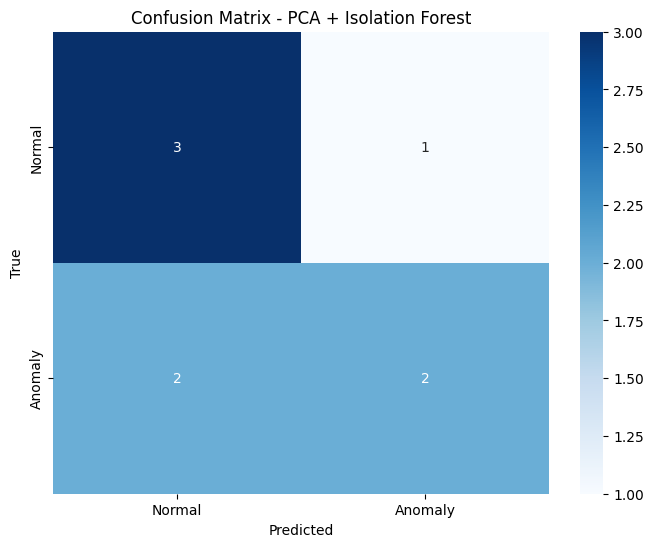

In [16]:
# Method 1: PCA + Isolation Forest
# Train Isolation Forest on normal data only
X_pca_train_normal = X_pca_train[y_pca_train == 0]

# Initialize and train Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_pca_train_normal)

# Predict on test data
# Isolation Forest returns 1 for normal points and -1 for anomalies
# We convert to 0 for normal and 1 for anomaly
y_pred_iso = (iso_forest.predict(X_pca_test) == -1).astype(int)

# Calculate evaluation metrics
accuracy_iso = accuracy_score(y_pca_test, y_pred_iso)
precision_iso = precision_score(y_pca_test, y_pred_iso)
recall_iso = recall_score(y_pca_test, y_pred_iso)
f1_iso = f1_score(y_pca_test, y_pred_iso)

print("Results for PCA + Isolation Forest:")
print(f"Accuracy: {accuracy_iso:.4f}")
print(f"Precision: {precision_iso:.4f}")
print(f"Recall: {recall_iso:.4f}")
print(f"F1 Score: {f1_iso:.4f}")

# Confusion matrix
cm_iso = confusion_matrix(y_pca_test, y_pred_iso)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - PCA + Isolation Forest')
plt.show()

Results for SVM:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


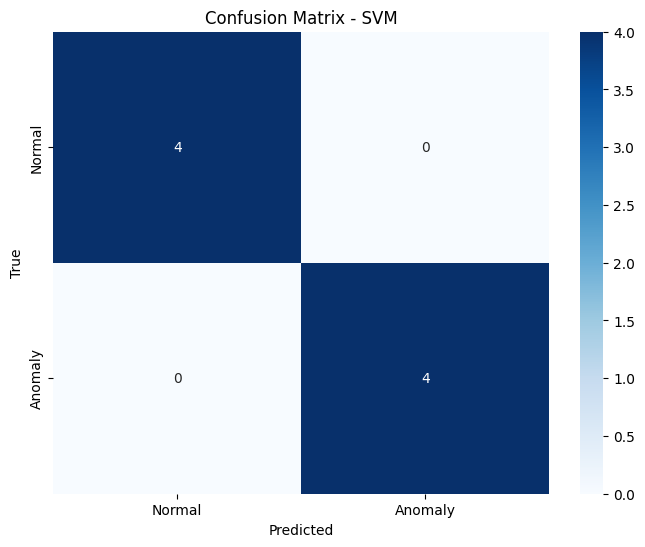

In [17]:
# Method 2: SVM
# Initialize and train SVM model
svm = SVC(kernel='rbf', gamma='scale', random_state=42)
svm.fit(X_pca_train, y_pca_train)

# Predict on test data
y_pred_svm = svm.predict(X_pca_test)

# Calculate evaluation metrics
accuracy_svm = accuracy_score(y_pca_test, y_pred_svm)
precision_svm = precision_score(y_pca_test, y_pred_svm)
recall_svm = recall_score(y_pca_test, y_pred_svm)
f1_svm = f1_score(y_pca_test, y_pred_svm)

print("Results for SVM:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")

# Confusion matrix
cm_svm = confusion_matrix(y_pca_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.show()

Results for Random Forest:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


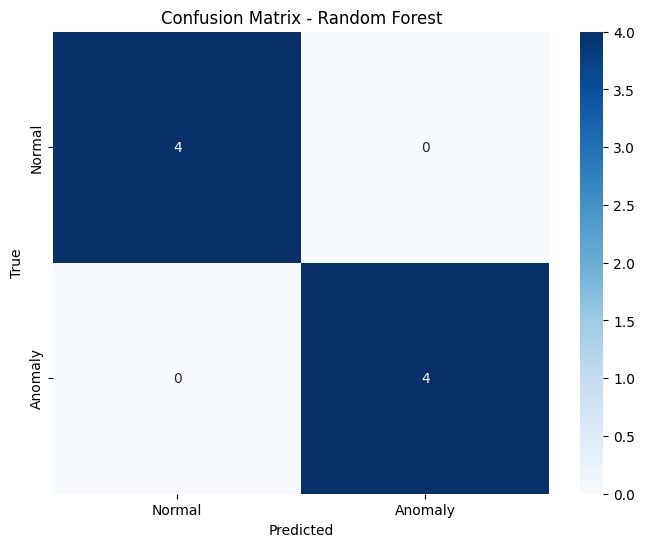

In [18]:
# Method 3: Random Forest
# Initialize and train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_pca_train, y_pca_train)

# Predict on test data
y_pred_rf = rf.predict(X_pca_test)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_pca_test, y_pred_rf)
precision_rf = precision_score(y_pca_test, y_pred_rf)
recall_rf = recall_score(y_pca_test, y_pred_rf)
f1_rf = f1_score(y_pca_test, y_pred_rf)

print("Results for Random Forest:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")

# Confusion matrix
cm_rf = confusion_matrix(y_pca_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Performance comparison of different methods:
                        Accuracy  Precision  Recall  F1-Score
Autoencoder                0.750   0.750000    0.75  0.750000
PCA + Isolation Forest     0.625   0.666667    0.50  0.571429
SVM                        1.000   1.000000    1.00  1.000000
Random Forest              1.000   1.000000    1.00  1.000000


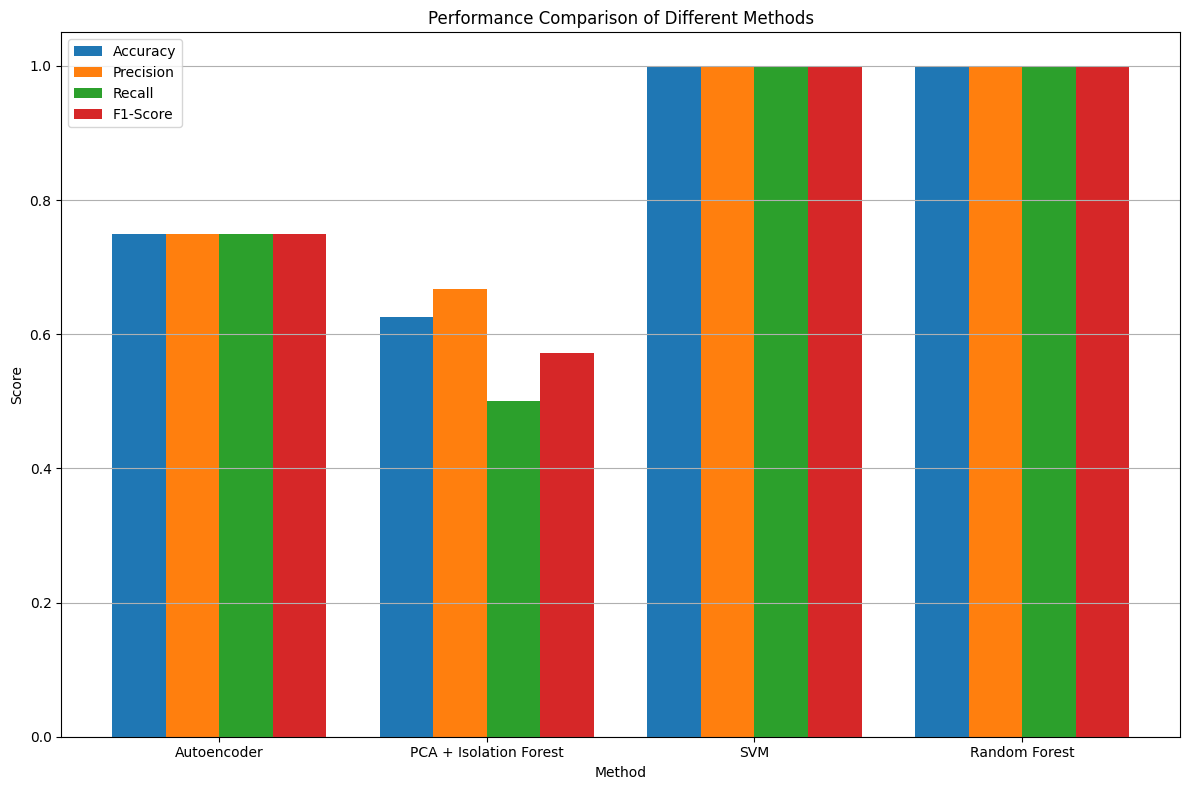

In [19]:
try:
    accuracy_ae = accuracy
    precision_ae = precision
    recall_ae = recall
    f1_ae = f1
except:
    accuracy_ae, precision_ae, recall_ae, f1_ae = 0, 0, 0, 0
    print("Warning: Metrics for autoencoder were not calculated previously.")

# Create DataFrame for comparison
methods = ['Autoencoder', 'PCA + Isolation Forest', 'SVM', 'Random Forest']
metrics = {
    'Accuracy': [accuracy_ae, accuracy_iso, accuracy_svm, accuracy_rf],
    'Precision': [precision_ae, precision_iso, precision_svm, precision_rf],
    'Recall': [recall_ae, recall_iso, recall_svm, recall_rf],
    'F1-Score': [f1_ae, f1_iso, f1_svm, f1_rf]
}

comparison_df = pd.DataFrame(metrics, index=methods)
print("Performance comparison of different methods:")
print(comparison_df)


plt.figure(figsize=(12, 8))


bar_width = 0.2
index = np.arange(len(methods))

plt.bar(index, metrics['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, metrics['Precision'], bar_width, label='Precision')
plt.bar(index + 2*bar_width, metrics['Recall'], bar_width, label='Recall')
plt.bar(index + 3*bar_width, metrics['F1-Score'], bar_width, label='F1-Score')

plt.xlabel('Method')
plt.ylabel('Score')
plt.title('Performance Comparison of Different Methods')
plt.xticks(index + 1.5*bar_width, methods)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 🔄 Part 3  - Visualization of the latent space

In this section, we will visualize the latent space using t-SNE and UMAP to better understand the structure of the data.

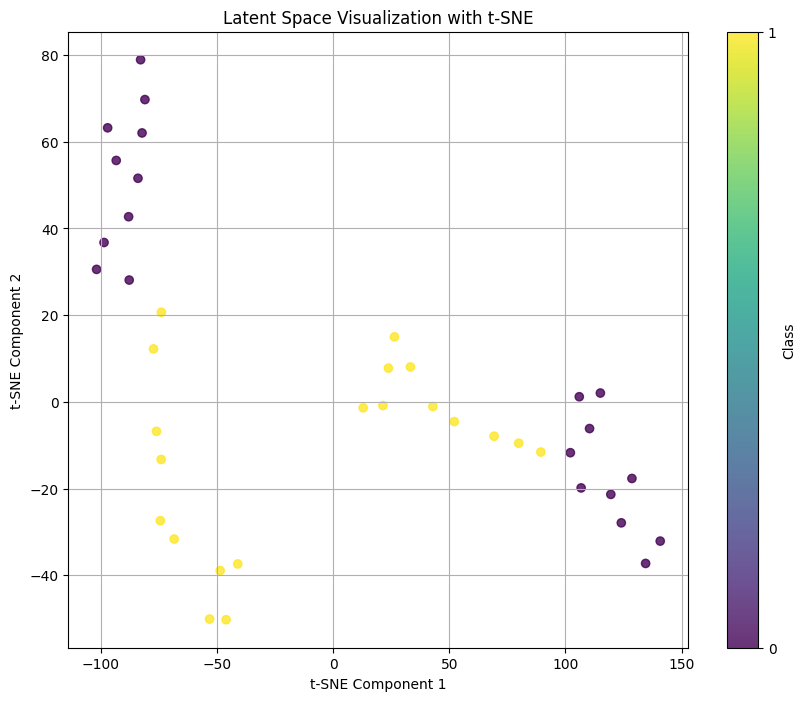

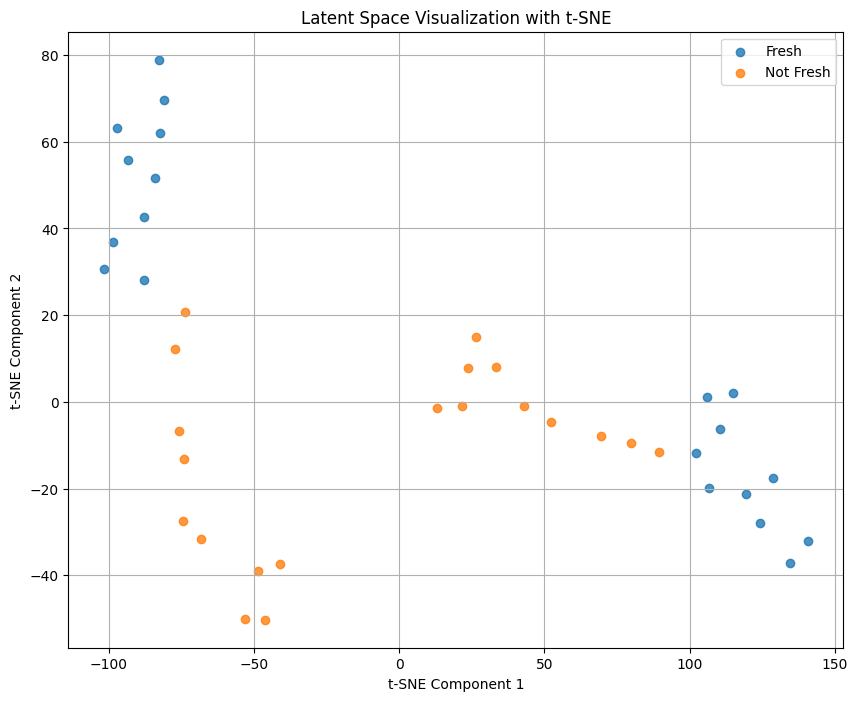

In [20]:

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
latent_tsne = tsne.fit_transform(latent_pca)

# Visualize t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=y, cmap='viridis', alpha=0.8)
plt.colorbar(scatter, ticks=[0, 1], label='Class')
plt.title('Latent Space Visualization with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

# Visualize t-SNE results with explicit legend
plt.figure(figsize=(10, 8))
for i, label in enumerate(['Fresh', 'Not Fresh']):
    plt.scatter(latent_tsne[y == i, 0], latent_tsne[y == i, 1], label=label, alpha=0.8)
plt.title('Latent Space Visualization with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()

UMAP not installed. Installing now...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


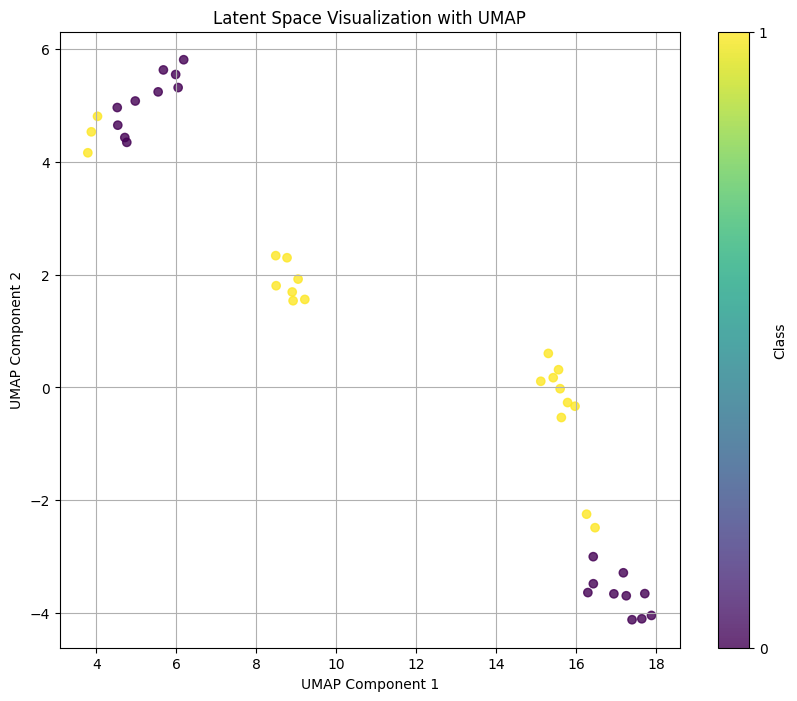

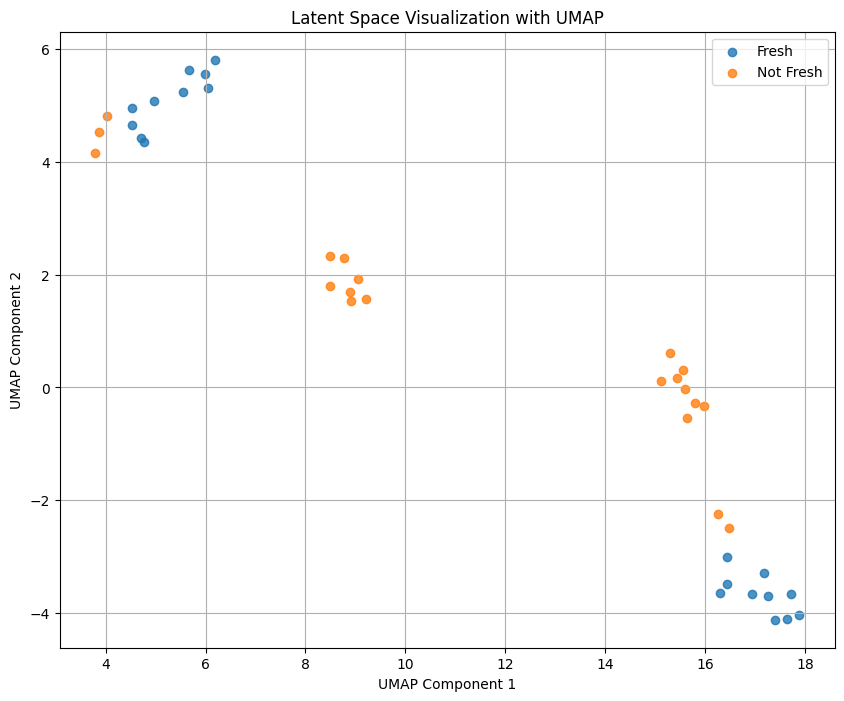

In [21]:
try:
    import umap
except ImportError:
    print("UMAP not installed. Installing now...")
    !pip install umap-learn

    import umap

# Apply UMAP to reduce dimensionality to 2 components
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5)
latent_umap = reducer.fit_transform(latent_pca)

# Visualize UMAP results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_umap[:, 0], latent_umap[:, 1], c=y, cmap='viridis', alpha=0.8)
plt.colorbar(scatter, ticks=[0, 1], label='Class')
plt.title('Latent Space Visualization with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

# Visualize UMAP results with explicit legend
plt.figure(figsize=(10, 8))
for i, label in enumerate(['Fresh', 'Not Fresh']):
    plt.scatter(latent_umap[y == i, 0], latent_umap[y == i, 1], label=label, alpha=0.8)
plt.title('Latent Space Visualization with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.grid(True)
plt.show()


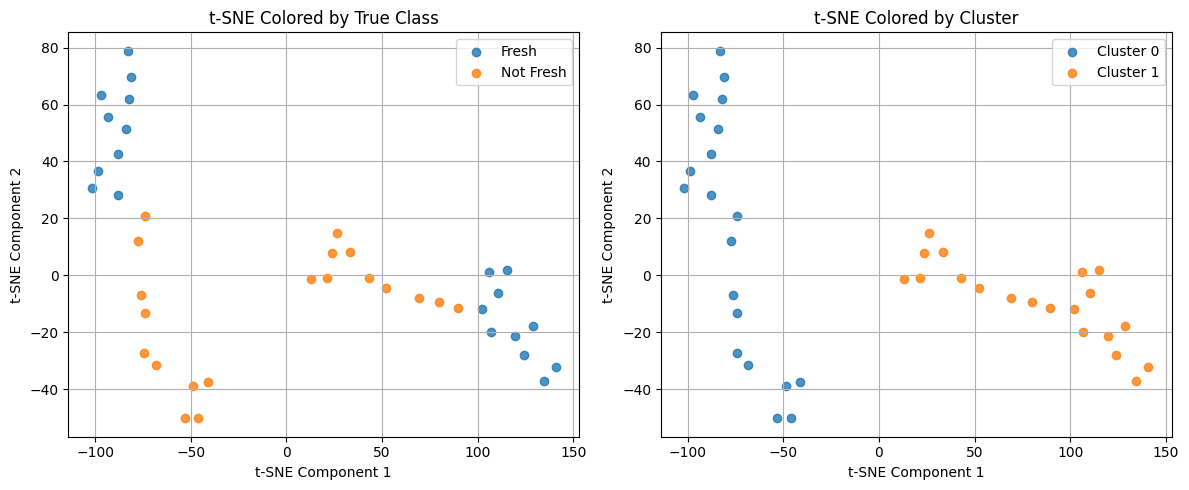

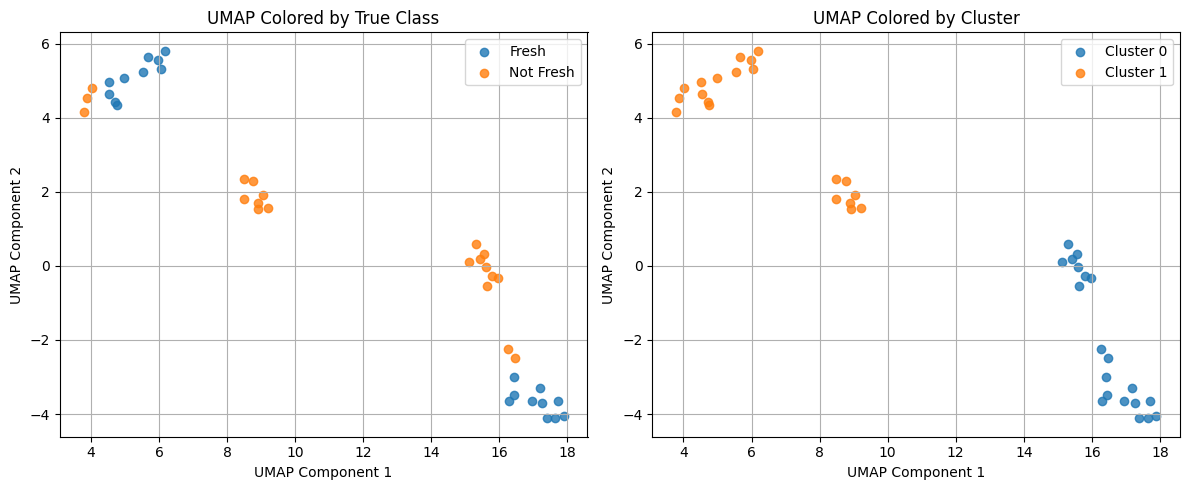

In [22]:

try:
    # Predict clusters for all data
    kmeans_all = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
    kmeans_all.fit(latent_pca)
    clusters_all = kmeans_all.predict(latent_pca)
    
    # Visualize clusters in t-SNE space
    plt.figure(figsize=(12, 5))
    
    # t-SNE colored by true class
    plt.subplot(1, 2, 1)
    for i, label in enumerate(['Fresh', 'Not Fresh']):
        plt.scatter(latent_tsne[y == i, 0], latent_tsne[y == i, 1], label=label, alpha=0.8)
    plt.title('t-SNE Colored by True Class')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.grid(True)
    
    # t-SNE colored by cluster
    plt.subplot(1, 2, 2)
    for i in range(optimal_n_clusters):
        plt.scatter(latent_tsne[clusters_all == i, 0], latent_tsne[clusters_all == i, 1], 
                    label=f'Cluster {i}', alpha=0.8)
    plt.title('t-SNE Colored by Cluster')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize clusters in UMAP space if available
    if 'latent_umap' in locals():
        plt.figure(figsize=(12, 5))
        
        # UMAP colored by true class
        plt.subplot(1, 2, 1)
        for i, label in enumerate(['Fresh', 'Not Fresh']):
            plt.scatter(latent_umap[y == i, 0], latent_umap[y == i, 1], label=label, alpha=0.8)
        plt.title('UMAP Colored by True Class')
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.legend()
        plt.grid(True)
        
        # UMAP colored by cluster
        plt.subplot(1, 2, 2)
        for i in range(optimal_n_clusters):
            plt.scatter(latent_umap[clusters_all == i, 0], latent_umap[clusters_all == i, 1], 
                        label=f'Cluster {i}', alpha=0.8)
        plt.title('UMAP Colored by Cluster')
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Error during cluster visualization: {e}")

# 📊 Conclusion and Comparison of Approaches

In this project, we explored different approaches for anomaly detection and multi-class classification on a dataset of fresh and non-fresh fish images:

1. **Part 1: Binary Anomaly Detection**
   - Using a convolutional autoencoder to learn a compact representation of fresh (normal) fish
   - Defining a threshold based on reconstruction error to detect anomalies

2. **Part 2: Multi-Class Classification**
   - **Option 1: Adaptive Multi-Thresholds**
     - Defining specific thresholds for each class
     - Classification based on reconstruction error
   - **Option 2: Clustering in the Latent Space**
     - Extracting the latent space with the autoencoder
     - Applying K-means to group products into categories
     - Evaluation using Adjusted Rand Index and Silhouette Score

3. **Part 3 :**
   - **Comparison with classical methods**
     - PCA + Isolation Forest
     - SVM
     - Random Forest
   - **Latent Space Visualization**
     - t-SNE
     - UMAP

The results show that each approach has its strengths and weaknesses:
- The autoencoder is particularly effective at capturing the complex structure of images
- Clustering methods in the latent space allow for discovering hidden structures in the data
- Classical methods like SVM and Random Forest can be simpler to implement and sometimes more effective on smaller datasets

Therefore, the choice of method depends on the specific context of the application and the project constraints.
